$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
$$
# Part 2: Optimization and Training
<a id=part2></a>

In this part we will learn how to implement optimization algorithms for deep networks. Additionally, we'll learn how to write training loops and implement a modular model trainer.
We'll use our optimizers and training code to test a few configurations for classifying images with an MLP model.

### Porting to Google Colab
The following cell enables this notebook to run from Google Colab as well as from your local machine IDE.<br>
You can change `root_directory` and/or `this_notebook_google_path` to point to the directory in your Google account, which contains this notebook, together with the `hw2` sub-directory and its class files, the `imgs` sub-directory and the rest of the files.<br>

In [16]:
try:
    from google.colab import drive
    import sys
    import os
    root_directory = '/content/gdrive/'
    this_notebook_google_path = root_directory + 'Othercomputers/My Laptop/projects/RUNI/DL_TA/hw2'
    drive.mount(root_directory)
    # enable import python files from this notebook's path
    sys.path.append(this_notebook_google_path)
    # enable reading images and data files from this notebook's path
    os.chdir(this_notebook_google_path)
except:
    # no Google Colab --> fall back to local machine
    pass


In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import unittest
import torch
import torchvision
import torchvision.transforms as tvtf

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
seed = 42
plt.rcParams.update({'font.size': 12})
test = unittest.TestCase()

In [19]:
def show_single_image(file_name: str) -> None:
    # Load the images
    image1 = mpimg.imread(file_name)

    # Create subplots with 1 row and 1 columns
    fig, axes = plt.subplots(1, 1, figsize=(10, 5))

    # Plot the first image on the left subplot
    axes.imshow(image1)
    axes.axis('off')  # Turn off axis
    axes.set_title(file_name)  # Set title

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()


## Implementing Optimization Algorithms
<a id=part2_1></a>

In the context of deep learning, an optimization algorithm is some method of iteratively updating model parameters so that the loss converges toward some local minimum (which we hope will be good enough).

Gradient descent-based methods are by far the most popular algorithms for optimization of neural network parameters.
However the high-dimensional loss-surfaces we encounter in deep learning applications are highly non-convex.
They may be riddled with local minima, saddle points, large plateaus and a host of very challenging "terrain" for gradient-based optimization.
This gave rise to many different methods of performing the parameter updates based on the loss gradients,
aiming to tackle these optimization challenges.

The most basic gradient-based update rule can be written as,

$$
\vec{\theta} \leftarrow \vec{\theta} - \eta \nabla_{\vec{\theta}} L(\vec{\theta}; \mathcal{D})
$$

where $\mathcal{D} = \left\{ (\vec{x}^i, \vec{y}^i) \right\}_{i=1}^{M}$ is our training dataset or part of it. Specifically, if we have in total $N$ training samples, then
- If $M=N$ this is known as regular gradient descent. If the dataset does not fit in memory the gradient of this loss becomes infeasible to compute.
- If $M=1$, the loss is computed w.r.t. a single different sample each time. This is known as stochastic gradient descent.
- If $1<M<N$ this is known as stochastic mini-batch gradient descent. This is the most commonly-used option.

The intuition behind gradient descent is simple: since the gradient of a multivariate function points to the direction of steepest ascent ("uphill"), we move in the opposite direction. A small step size $\eta$ known as the **learning rate** is required since the gradient can only serve as a first-order linear approximation of the function's behaviour at $\vec{\theta}$ (recall e.g. the Taylor expansion).
However in truth our loss surface generally has nontrivial curvature caused by a high order nonlinear dependency on
$\vec{\theta}$.
Thus taking a large step in the direction of the gradient is actually just as likely to increase the function value.

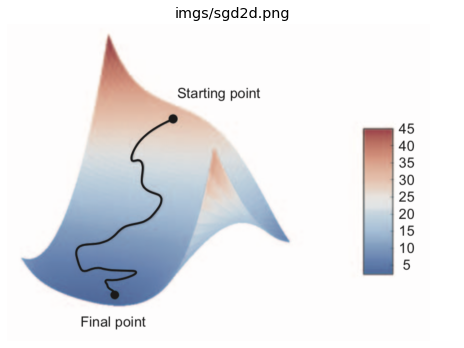

In [20]:
show_single_image('imgs/sgd2d.png')

The idea behind the stochastic versions is that by constantly changing the samples we compute the loss with,
we get a dynamic error surface, i.e. it's different for each set of training samples.
This is thought to generally improve the optimization since it may help the optimizer get out of flat regions or sharp local minima since these features may disappear in the loss surface of subsequent batches. The image below illustrates this. The different lines are different 1-dimensional losses for different training set-samples.

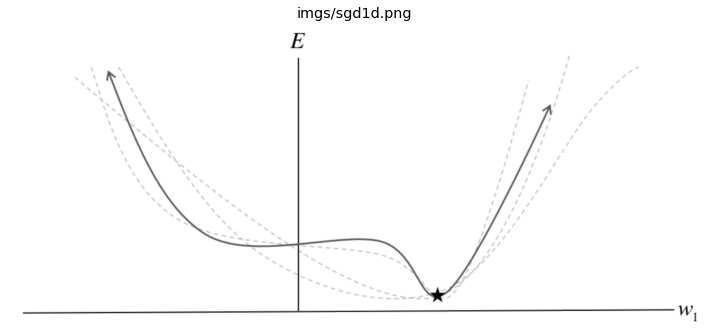

In [21]:
show_single_image('imgs/sgd1d.png')

Deep learning frameworks generally provide implementations of various gradient-based optimization algorithms.
Here we'll implement our own optimization module from scratch, this time keeping a similar API to the PyTorch `optim` package.

We define a base `Optimizer` class. An optimizer holds a set of parameter tensors (these are the trainable parameters of some model) and maintains internal state. It may be used as follows:
- After the forward pass has been performed the optimizer's `zero_grad()` function is invoked to clear the parameter gradients computed by previous iterations.
- After the backward pass has been performed, and gradients have been calculated for these parameters, the optimizer's `step()` function is invoked in order to update the value of each parameter based on it's gradient.

The exact method of update is implementation-specific for each optimizer and may depend on its internal state. In addition, adding the regularization penalty to the gradient is handled by the optimizer since it only depends on the parameter values (and not the data).

Here's the API of our `Optimizer`:

In [22]:
import hw2.optimizers as optimizers
help(optimizers.Optimizer)

Help on class Optimizer in module hw2.optimizers:

class Optimizer(abc.ABC)
 |  Optimizer(params)
 |  
 |  Base class for optimizers.
 |  
 |  Method resolution order:
 |      Optimizer
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, params)
 |      :param params: A sequence of model parameters to optimize. Can be a
 |      list of (param,grad) tuples as returned by the Layers, or a list of
 |      pytorch tensors in which case the grad will be taken from them.
 |  
 |  step(self)
 |      Updates all the registered parameter values based on their gradients.
 |  
 |  zero_grad(self)
 |      Sets the gradient of the optimized parameters to zero (in place).
 |  
 |  ----------------------------------------------------------------------
 |  Readonly properties defined here:
 |  
 |  params
 |      :return: A sequence of parameter tuples, each tuple containing
 |      (param_data, param_grad). The data should be updated in-place
 |      accordi

## Vanilla SGD with Regularization
<a id=part2_2></a>

Let's start by implementing the simplest gradient based optimizer. The update rule will be exacly as stated above, but we'll also add a L2-regularization term to the gradient. Remember that in the **loss function**, the L2 regularization term is expressed by

$$R(\vec{\theta}) = \frac{1}{2}\lambda||\vec{\theta}||^2_2.$$

**TODO**: Complete the implementation of the `VanillaSGD` class in the `hw2/optimizers.py` module.

In [23]:
# Test VanillaSGD
torch.manual_seed(42)
p = torch.randn(500, 10)
dp = torch.randn(*p.shape)*2
params = [(p, dp)]

vsgd = optimizers.VanillaSGD(params, learn_rate=0.5, reg=0.1)
vsgd.step()

expected_p = torch.load('tests/assets/expected_vsgd.pt')
diff = torch.norm(p-expected_p).item()
print(f'diff={diff}')
test.assertLess(diff, 1e-3)

diff=0.0


## Training
<a id=part2_3></a>

Now that we can build a model and loss function, compute their gradients and we have an optimizer, we can finally do some training!

In the spirit of more modular software design, we'll implement a class that will aid us in automating the repetitive training loop code that we usually write over and over again. This will be useful for both training our `Layer`-based models and also later for training PyTorch `nn.Module`s.

Here's our `Trainer` API:

In [24]:
import hw2.training as training
help(training.Trainer)

Help on class Trainer in module hw2.training:

class Trainer(abc.ABC)
 |  Trainer(model: torch.nn.modules.module.Module, device: Optional[torch.device] = None)
 |  
 |  A class abstracting the various tasks of training models.
 |  
 |  Provides methods at multiple levels of granularity:
 |  - Multiple epochs (fit)
 |  - Single epoch (train_epoch/test_epoch)
 |  - Single batch (train_batch/test_batch)
 |  
 |  Method resolution order:
 |      Trainer
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, model: torch.nn.modules.module.Module, device: Optional[torch.device] = None)
 |      Initialize the trainer.
 |      :param model: Instance of the model to train.
 |      :param device: torch.device to run training on (CPU or GPU).
 |  
 |  fit(self, dl_train: torch.utils.data.dataloader.DataLoader, dl_test: torch.utils.data.dataloader.DataLoader, num_epochs: int, checkpoints: str = None, early_stopping: int = None, print_every: int = 1, **kw) ->

The `Trainer` class splits the task of training (and evaluating) models into three conceptual levels,
- Multiple epochs - the `fit` method, which returns a `FitResult` containing losses and accuracies for all epochs.
- Single epoch - the `train_epoch` and `test_epoch` methods, which return an `EpochResult` containing losses per batch and the single accuracy result of the epoch.
- Single batch - the `train_batch` and `test_batch` methods, which return a `BatchResult` containing a single loss and the number of correctly classified samples in the batch.

It implements the first two levels. Inheriting classes are expected to implement the single-batch level methods since these are model and/or task specific.

The first thing we should do in order to verify our model, gradient calculations and optimizer implementation is to try to overfit a large model (many parameters) to a small dataset (few images). This will show us that things are working properly.

Let's begin by loading the CIFAR-10 dataset.

In [25]:
data_dir = os.path.expanduser('~/.pytorch-datasets')
cifar10_mlp_transforms = tvtf.Compose([tvtf.ToTensor(), tvtf.Lambda(lambda x: torch.flatten(x))])
ds_train = torchvision.datasets.CIFAR10(root=data_dir, download=True, train=True, transform=cifar10_mlp_transforms)
ds_test = torchvision.datasets.CIFAR10(root=data_dir, download=True, train=False, transform=cifar10_mlp_transforms)

print(f'Train: {len(ds_train)} samples')
print(f'Test: {len(ds_test)} samples')

Files already downloaded and verified
Files already downloaded and verified
Train: 50000 samples
Test: 10000 samples


Now, let's implement just a small part of our training logic since that's what we need right now.

**TODO**:
1. Complete the implementation of the `train_batch()` method in the `LayerTrainer` class within the `hw2/training.py` module.
1. Update the hyperparameter values in the `part2_overfit_hp()` function in the `hw2/answers.py` module. Tweak the hyperparameter values until your model overfits a small number of samples in the code block below. You should get 100% accuracy within a few epochs.

The following code block will use your custom `Layer`-based MLP implentation, custom Vanilla SGD and custom trainer to overfit the data. The classification accuracy should be 100% within a few epochs.

In [26]:
import hw2.layers as layers
import hw2.answers as answers
from torch.utils.data import DataLoader

# Overfit to a very small dataset of 20 samples
batch_size = 10
max_batches = 2
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=False)

# Get hyperparameters
hp = answers.part2_overfit_hp()

torch.manual_seed(seed)

# Build a model and loss using our custom MLP and CE implementations
model = layers.MLP(3*32*32, num_classes=10, hidden_features=[128]*3, wstd=hp['wstd'])
loss_fn = layers.CrossEntropyLoss()

# Use our custom optimizer
optimizer = optimizers.VanillaSGD(model.params(), learn_rate=hp['lr'], reg=hp['reg'])

# Run training over small dataset multiple times
trainer = training.LayerTrainer(model, loss_fn, optimizer)
best_acc = 0
for i in range(20):
    res = trainer.train_epoch(dl_train, max_batches=max_batches)
    best_acc = res.accuracy if res.accuracy > best_acc else best_acc

test.assertGreaterEqual(best_acc, 98)

train_batch:   0%|          | 0/2 [00:00<?, ?it/s]

train_batch:   0%|          | 0/2 [00:00<?, ?it/s]

train_batch:   0%|          | 0/2 [00:00<?, ?it/s]

train_batch:   0%|          | 0/2 [00:00<?, ?it/s]

train_batch:   0%|          | 0/2 [00:00<?, ?it/s]

train_batch:   0%|          | 0/2 [00:00<?, ?it/s]

train_batch:   0%|          | 0/2 [00:00<?, ?it/s]

train_batch:   0%|          | 0/2 [00:00<?, ?it/s]

train_batch:   0%|          | 0/2 [00:00<?, ?it/s]

train_batch:   0%|          | 0/2 [00:00<?, ?it/s]

train_batch:   0%|          | 0/2 [00:00<?, ?it/s]

train_batch:   0%|          | 0/2 [00:00<?, ?it/s]

train_batch:   0%|          | 0/2 [00:00<?, ?it/s]

train_batch:   0%|          | 0/2 [00:00<?, ?it/s]

train_batch:   0%|          | 0/2 [00:00<?, ?it/s]

train_batch:   0%|          | 0/2 [00:00<?, ?it/s]

train_batch:   0%|          | 0/2 [00:00<?, ?it/s]

train_batch:   0%|          | 0/2 [00:00<?, ?it/s]

train_batch:   0%|          | 0/2 [00:00<?, ?it/s]

train_batch:   0%|          | 0/2 [00:00<?, ?it/s]

Now that we know training works, let's try to fit a model to a bit more data for a few epochs, to see how well we're doing. First, we need a function to plot the FitResults object.

In [27]:
from cs236781.plot import plot_fit
plot_fit

<function cs236781.plot.plot_fit(fit_res: cs236781.train_results.FitResult, fig=None, log_loss=False, legend=None, train_test_overlay: bool = False)>

**TODO**:
1. Complete the implementation of the `test_batch()` method in the `LayerTrainer` class within the `hw2/training.py` module.
1. Implement the `fit()` method of the `Trainer` class within the `hw2/training.py` module.
1. Tweak the hyperparameters for this section in the `part2_optim_hp()` function in the `hw2/answers.py` module.
1. Run the following code blocks to train. Try to get above 35-40% test-set accuracy.

In [28]:
# Define a larger part of the CIFAR-10 dataset (still not the whole thing)
batch_size = 50
max_batches = 100
in_features = 3*32*32
num_classes = 10
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=False)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size//2, shuffle=False)

In [29]:
# Define a function to train a model with our Trainer and various optimizers
def train_with_optimizer(opt_name, opt_class, fig):
    torch.manual_seed(seed)

    # Get hyperparameters
    hp = answers.part2_optim_hp()
    hidden_features = [128] * 5
    num_epochs = 10

    # Create model, loss and optimizer instances
    model = layers.MLP(in_features, num_classes, hidden_features, wstd=hp['wstd'])
    loss_fn = layers.CrossEntropyLoss()
    optimizer = opt_class(model.params(), learn_rate=hp[f'lr_{opt_name}'], reg=hp['reg'])

    # Train with the Trainer
    trainer = training.LayerTrainer(model, loss_fn, optimizer)
    fit_res = trainer.fit(dl_train, dl_test, num_epochs, max_batches=max_batches)

    fig, axes = plot_fit(fit_res, fig=fig, legend=opt_name)
    return fig

--- EPOCH 1/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

--- EPOCH 2/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

--- EPOCH 3/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

--- EPOCH 4/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

--- EPOCH 5/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

--- EPOCH 6/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

--- EPOCH 7/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

--- EPOCH 8/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

--- EPOCH 9/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

--- EPOCH 10/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

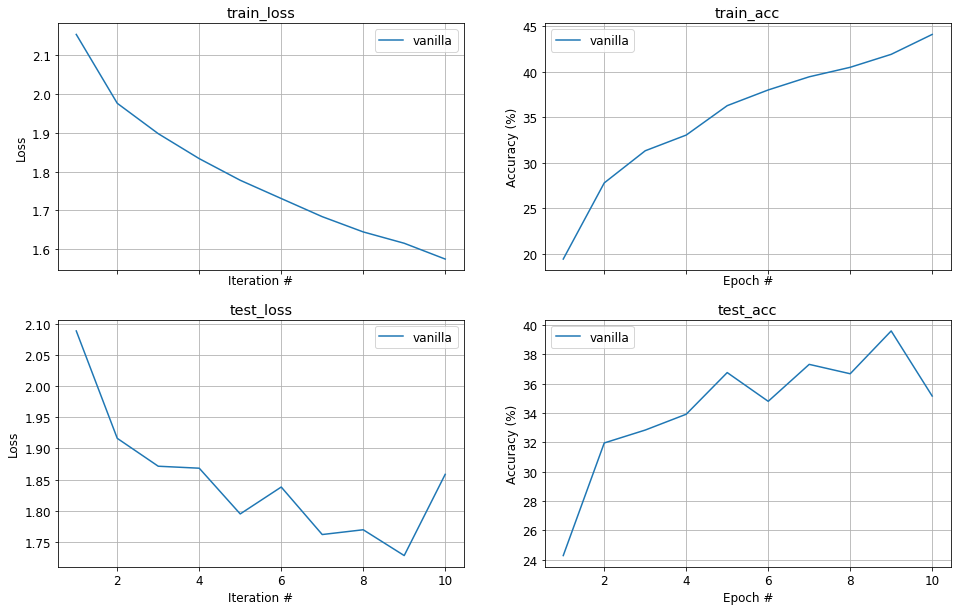

In [30]:
fig_optim = None
fig_optim = train_with_optimizer('vanilla', optimizers.VanillaSGD, fig_optim)

## Momentum
<a id=part2_4></a>

The simple vanilla SGD update is rarely used in practice since it's very slow to converge relative to other optimization algorithms.

One reason is that naïvely updating in the direction of the current gradient causes it to fluctuate wildly in areas where the loss surface in some dimensions is much steeper than in others.
Another reason is that using the same learning rate for all parameters is not a great idea since not all parameters are created equal. For example, parameters associated with rare features should be updated with a larger step than ones associated with commonly-occurring features because they'll get less updates through the gradients.

Therefore more advanced optimizers take into account the previous gradients of a parameter and/or try to use a per-parameter specific learning rate instead of a common one.

Let's now implement a simple and common optimizer: SGD with Momentum. This optimizer takes **previous gradients** of a parameter into account when updating it's value instead of just the current one. In practice it usually provides faster convergence than the vanilla SGD.

The SGD with Momentum update rule can be stated as follows:
$$\begin{align}
\vec{v}_{t+1} &= \mu \vec{v}_t - \eta \delta \vec{\theta}_t \\
\vec{\theta}_{t+1} &= \vec{\theta}_t + \vec{v}_{t+1}
\end{align}$$

Where $\eta$ is the learning rate,
$\vec{\theta}$ is a model parameter,
$\delta \vec{\theta}_t=\pderiv{L}{\vec{\theta}}(\vec{\theta}_t)$ is the gradient of the loss w.r.t. to the parameter and $0\leq\mu<1$ is a hyperparameter known as momentum.

Expanding the update rule recursively shows us now the parameter update infact depends on all previous gradient values for that parameter, where the old gradients are exponentially decayed by a factor of $\mu$ at each timestep.

Since we're incorporating previous gradient (update directions), a noisy value of the current gradient will have less effect so that the general direction of previous updates is maintained somewhat. The following figure illustrates this.


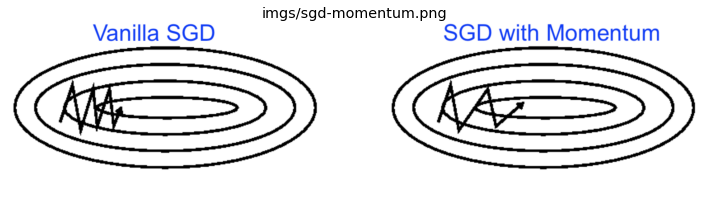

In [31]:
show_single_image('imgs/sgd-momentum.png')

**TODO**:
1. Complete the implementation of the `MomentumSGD` class in the `hw2/optimizers.py` module.
1. Tweak the learning rate for momentum in `part2_optim_hp()` the function in the `hw2/answers.py` module.
1. Run the following code block to compare to the vanilla SGD.

--- EPOCH 1/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

--- EPOCH 2/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

--- EPOCH 3/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

--- EPOCH 4/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

--- EPOCH 5/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

--- EPOCH 6/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

--- EPOCH 7/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

--- EPOCH 8/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

--- EPOCH 9/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

--- EPOCH 10/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

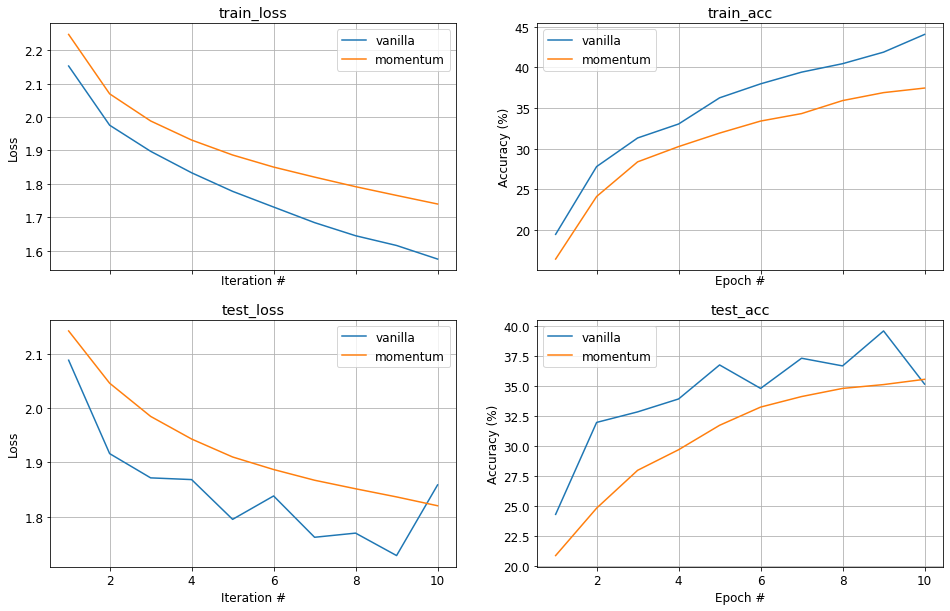

In [32]:
fig_optim = train_with_optimizer('momentum', optimizers.MomentumSGD, fig_optim)
fig_optim

## Bonus: RMSProp
<a id=part2_5></a>

This is another optmizer that accounts for previous gradients, but this time it uses them to adapt the learning rate per parameter.

RMSProp maintains a decaying moving average of previous squared gradients,
$$
\vec{r}_{t+1} = \gamma\vec{r}_{t} + (1-\gamma)\delta\vec{\theta}_t^2
$$
where $0<\gamma<1$ is a decay constant usually set close to $1$, and $\delta\vec{\theta}_t^2$ denotes
element-wise squaring.

The update rule for each parameter is then,
$$
\vec{\theta}_{t+1} = \vec{\theta}_t - \left( \frac{\eta}{\sqrt{r_{t+1}+\varepsilon}} \right) \delta\vec{\theta}_t
$$

where $\varepsilon$ is a small constant to prevent numerical instability. The idea here is to decrease the learning rate for parameters with high gradient values and vice-versa. The decaying moving average prevents accumulating all the past gradients which would cause the effective learning rate to become zero.

**Bonus**:
1. Complete the implementation of the `RMSProp` class in the `hw2/optimizers.py` module.
1. Tweak the learning rate for RMSProp in `part2_optim_hp()` the function in the `hw2/answers.py` module.
1. Run the following code block to compare to the other optimizers.

--- EPOCH 1/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

--- EPOCH 2/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

--- EPOCH 3/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

--- EPOCH 4/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

--- EPOCH 5/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

--- EPOCH 6/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

--- EPOCH 7/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

--- EPOCH 8/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

--- EPOCH 9/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

--- EPOCH 10/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

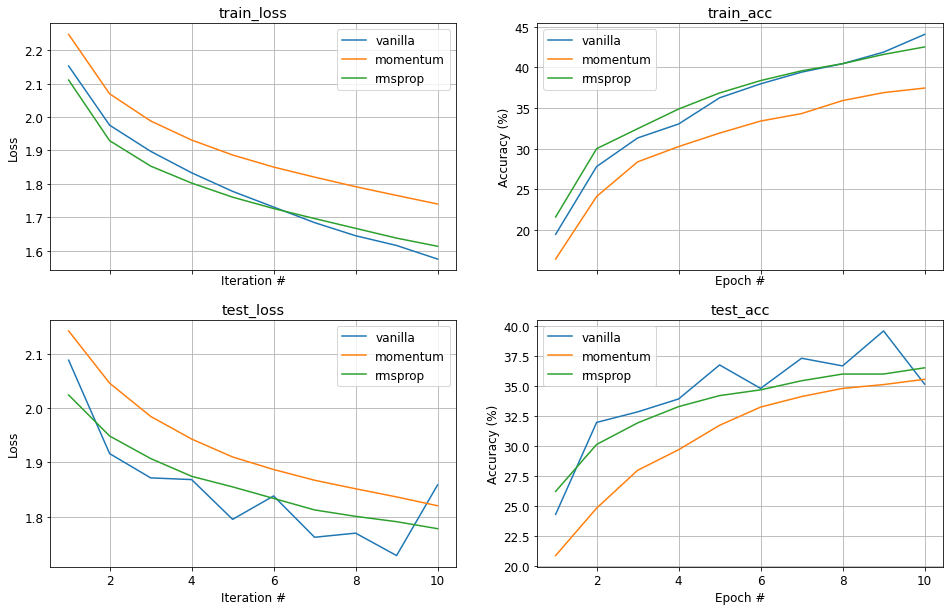

In [33]:
fig_optim = train_with_optimizer('rmsprop', optimizers.RMSProp, fig_optim)
fig_optim

Note that you should get better train/test accuracy with Momentum and RMSProp than Vanilla.

## Dropout Regularization
<a id=part2_6></a>

[Dropout](http://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf) is a useful technique to improve generalization of deep models.

The idea is simple: during the forward pass drop, i.e. set to to zero, the activation of each neuron, with a probability of $p$. For example, if $p=0.4$ this means we **drop** the activations of 40% of the neurons (on average).

There are a few important things to note about dropout:
1. It is only performed during training. When testing our model the dropout layers should be a no-op.
1. In the backward pass, gradients are only propagated back into neurons that weren't dropped during the forward pass.
1. During testing, the activations must be scaled since the expected value of each neuron during the training phase is now $1-p$ times it's original expectation. Thus, we need to scale the test-time activations by $1-p$ to match. Equivalently, we can scale the train time activations by $1/(1-p)$.

**TODO**:
1. Complete the implementation of the `Dropout` class in the `hw2/layers.py` module.
2. Finish the implementation of the `MLP`'s `__init__()` method in the `hw2/layers.py` module.
   If `dropout>0` you should add a `Dropout` layer after each `ReLU`.

In [34]:
from hw2.grad_compare import compare_layer_to_torch

# Check architecture of MLP with dropout layers
mlp_dropout = layers.MLP(in_features, num_classes, [50]*3, dropout=0.6)
print(mlp_dropout)
test.assertEqual(len(mlp_dropout.sequence), 10)
for b1, b2 in zip(mlp_dropout.sequence, mlp_dropout.sequence[1:]):
    if str(b1).lower() == 'relu':
        test.assertTrue(str(b2).startswith('Dropout'))
test.assertTrue(str(mlp_dropout.sequence[-1]).startswith('Linear'))

MLP, Sequential
	[0] Linear(self.in_features=3072, self.out_features=50)
	[1] ReLU
	[2] Dropout(p=0.6)
	[3] Linear(self.in_features=50, self.out_features=50)
	[4] ReLU
	[5] Dropout(p=0.6)
	[6] Linear(self.in_features=50, self.out_features=50)
	[7] ReLU
	[8] Dropout(p=0.6)
	[9] Linear(self.in_features=50, self.out_features=10)



In [35]:
# Test end-to-end gradient in train and test modes.
print('Dropout, train mode')
mlp_dropout.train(True)
for diff in compare_layer_to_torch(mlp_dropout, torch.randn(500, in_features)):
    test.assertLess(diff, 1e-3)

print('Dropout, test mode')
mlp_dropout.train(False)
for diff in compare_layer_to_torch(mlp_dropout, torch.randn(500, in_features)):
    test.assertLess(diff, 1e-3)

Dropout, train mode
Comparing gradients... 
input    diff=0.000
param#01 diff=0.000
param#02 diff=0.000
param#03 diff=0.000
param#04 diff=0.000
param#05 diff=0.000
param#06 diff=0.000
param#07 diff=0.000
param#08 diff=0.000
Dropout, test mode
Comparing gradients... 
input    diff=0.000
param#01 diff=0.000
param#02 diff=0.000
param#03 diff=0.000
param#04 diff=0.000
param#05 diff=0.000
param#06 diff=0.000
param#07 diff=0.000
param#08 diff=0.000


To see whether dropout really improves generalization, let's take a small training set
(small enough to overfit) and a large test set and check whether we get less overfitting and
perhaps improved test-set accuracy when using dropout.

In [36]:
# Define a small set from CIFAR-10, but take a larger test set since we want to test generalization
batch_size = 10
max_batches = 40
in_features = 3*32*32
num_classes = 10
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=False)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size*2, shuffle=False)

**TODO**:
Tweak the hyperparameters for this section in the `part2_dropout_hp()` function in the `hw2/answers.py` module. Try to set them so that the first model (with `dropout`=0) overfits. You can disable the other dropout options until you tune the hyperparameters. We can then see the effect of dropout for generalization.

In [37]:
# Get hyperparameters
hp = answers.part2_dropout_hp()
hidden_features = [400] * 1
num_epochs = 30

*** Training with dropout= 0
--- EPOCH 1/30 ---


train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

--- EPOCH 7/30 ---


train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

--- EPOCH 13/30 ---


train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

--- EPOCH 19/30 ---


train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

--- EPOCH 25/30 ---


train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

--- EPOCH 30/30 ---


train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

*** Training with dropout= 0.4
--- EPOCH 1/30 ---


train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

--- EPOCH 7/30 ---


train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

--- EPOCH 13/30 ---


train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

--- EPOCH 19/30 ---


train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

--- EPOCH 25/30 ---


train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

--- EPOCH 30/30 ---


train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

*** Training with dropout= 0.8
--- EPOCH 1/30 ---


train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

--- EPOCH 7/30 ---


train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

--- EPOCH 13/30 ---


train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

--- EPOCH 19/30 ---


train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

--- EPOCH 25/30 ---


train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

--- EPOCH 30/30 ---


train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

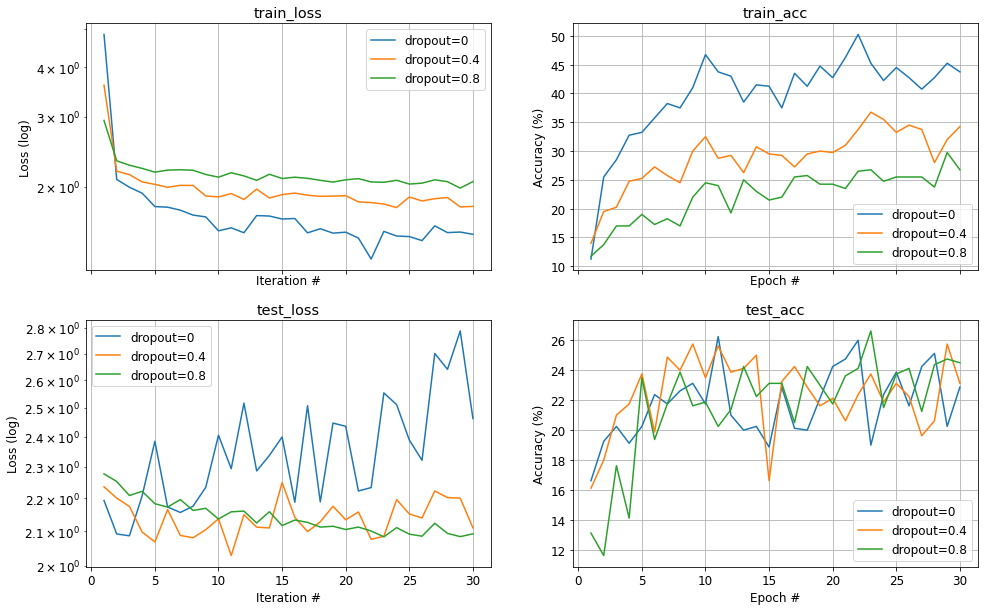

In [38]:
torch.manual_seed(seed)
fig=None
#for dropout in [0]:  # Use this for tuning the hyperparms until you overfit
for dropout in [0, 0.4, 0.8]:
    model = layers.MLP(in_features, num_classes, hidden_features, wstd=hp['wstd'], dropout=dropout)
    loss_fn = layers.CrossEntropyLoss()
    optimizer = optimizers.MomentumSGD(model.params(), learn_rate=hp['lr'], reg=0)

    print('*** Training with dropout=', dropout)
    trainer = training.LayerTrainer(model, loss_fn, optimizer)
    fit_res_dropout = trainer.fit(dl_train, dl_test, num_epochs, max_batches=max_batches, print_every=6)
    fig, axes = plot_fit(fit_res_dropout, fig=fig, legend=f'dropout={dropout}', log_loss=True)

## Questions
<a id=part2_7></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw2/answers.py`.

In [81]:
from cs236781.answers import display_answer
import hw2.answers

### Question 1

Regarding the graphs you got for the three dropout configurations:

1. Explain the graphs of no-dropout vs dropout. Do they match what you expected to see?
    - If yes, explain why and provide examples based on the graphs.
    - If no, explain what you think the problem is and what should be modified to fix it.

2. Compare the low-dropout setting to the high-dropout setting and explain based on your graphs.

In [82]:
display_answer(hw2.answers.part2_q1)



The graphs align with our expectations.
With a high dropout rate of 0.8, the training accuracy is lower compared to the scenario with no dropout, as neural networks trained with lower dropout rates tend to overfit the data.

Since dropout is a regularization technique, we anticipate that the neural network will perform better on the test dataset when regularization is applied with a higher probability. Consequently, in the test accuracy results, the neural network with a high dropout rate shows higher accuracy due to its improved generalization.



### Question 2

When training a model with the cross-entropy loss function, is it possible for the test loss to **increase** for a few epochs while the test accuracy also **increases**?

If it's possible explain how, if it's not explain why not.

In [83]:
display_answer(hw2.answers.part2_q2)



Both cross-entropy loss and accuracy can simultaneously increase during the testing phase. Accuracy measures the ratio of correctly classified samples by selecting the maximum argument in the probability vector induced by cross-entropy. The loss is calculated using the formula $-y^t \log(\hat{y})$, which is equivalent to $-x_i + \log(e^{x_1} + ... + e^{x_n})$, where $i$ is the correct output label.

This scenario can occur if the entropy increases while the correct label retains the highest probability. For instance, consider a mini-batch with two samples. The cross-entropy loss might decrease for one sample but increase more for the other, leading to an overall increase in the average cross-entropy loss, even though the classification accuracy improves.

For example, in binary classification, suppose in the first epoch we have the following softmax activations:
1. $[0.1, 0.9]$ with the correct label $[0, 1]$
2. $[0.49, 0.51]$ with the correct label $[1, 0]$

In the second epoch, the activations change to:
1. $[0.4, 0.6]$ with the correct label $[0, 1]$
2. $[0.51, 0.49]$ with the correct label $[1, 0]$

The accuracy for the first mini-batch is 50%, and for the second mini-batch, it is 100%, showing an increase.

The loss for the first mini-batch is:
$
\left( -0.9 + \log(e^{0.1} + e^{0.9}) - 0.49 + \log(e^{0.49} + e^{0.51}) \right) / 2 = 0.5371 
$

The loss for the second mini-batch is:
$
\left( -0.6 + \log(e^{0.4} + e^{0.6}) - 0.51 + \log(e^{0.49} + e^{0.51}) \right) / 2 = 0.64 
$

Thus, both loss and accuracy increase.

In the initial epochs, the classifier might achieve higher accuracy, but the cross-entropy loss can increase, leading to an overall increase in loss. This issue typically resolves after a few batches as the cross-entropy between the model's predictions and the true distribution decreases.



### Question 3

1. Explain the difference between gradient descent and back-propagation.

2. Compare in detail between gradient descent (GD) and stochastic gradient descent (SGD).

3. Why is SGD used more often in the practice of deep learning? Provide a few justifications.

4. You would like to try GD to train your model instead of SGD, but you're concerned that your dataset won't fit in memory. A friend suggested that you should split the data into disjoint batches, do multiple forward passes until all data is exhausted, and then do one backward pass on the sum of the losses.
   1. Would this approach produce a gradient equivalent to GD? Why or why not? provide mathematical justification for your answer.
   2. You implemented the suggested approach, and were careful to use batch sizes small enough so that each batch fits in memory. However, after some number of batches you got an out of memory error. What happened?


In [84]:
display_answer(hw2.answers.part2_q3)



1) Backpropagation is a method for training neural networks by using the chain rule to calculate the derivative of the loss function with respect to parameters like weights and biases. Gradient descent is a general method for finding a local minimum of a function by taking steps in the direction of the gradient, which points to the steepest ascent. Negating the gradient points to the steepest descent. The assumption is that updating parameters in the direction of steepest descent of the loss function will lead to a local, or often global, minimum of the loss function.

2) In gradient descent, the gradient of the loss is calculated using the entire training dataset, requiring \(N\) calculations, whereas stochastic gradient descent (SGD) samples uniformly from the dataset, requiring only one calculation per iteration. With SGD, convergence isn't guaranteed in every iteration but over many iterations, the expected value approximates the true gradient. In gradient descent, the gradient closely resembles the expected value in every iteration due to using \(N\) samples. When far from the minima, SGD converges more rapidly than gradient descent but stays at a higher loss near the minima because updates are based on randomly picked samples, never fully capturing the optimal direction. SGD's convergence rate is sublinear $((O(1/k)))$, while gradient descent has a linear rate $((O(c^k)))$.

3) To achieve a norm of less than $(\epsilon > 0)$ between the $(k)$-th iteration parameters and the minimizer, SGD requires $(O(1/\epsilon))$ resources, independent of $(N)$. Gradient descent requires $(O(N \log(1/\epsilon)))$ resources, dependent on $(N)$. Given large datasets and limited computational resources, SGD is often more practical. Additionally, SGD quickly minimizes loss compared to gradient descent, even though its asymptotic loss is slightly higher.

4) In SGD, the distance between the minima and the parameters in the \(k\)-th iteration decreases sublinearly, i.e., \(O(1/k)\). In gradient descent, the rate of convergence is linear, i.e., \(O(c^k)\).


To achieve a norm of less than \(\epsilon > 0\) in Euclidean norm between the \(k\)-th iteration parameters and the minimizer, SGD requires \(O(1/\epsilon)\) computational resources, which is independent of \(N\) (training set size). Gradient descent requires \(O(N \log(1/\epsilon))\) resources, which is dependent on \(N\). In real-world settings, datasets are usually very large and computational resources are limited, making SGD more relevant. Additionally, SGD minimizes loss more quickly compared to gradient descent, even though the asymptotic loss is slightly higher with SGD.

When training with gradient descent during backpropagation, weights are updated by multiplying \(d_{\text{out}} * W^T\), where \(d_{\text{out}}\) has dimensions \((d_{\text{out}}, N)\) and \(W\) has dimensions \((d_{\text{in}}, N)\). In the described approach, the change in \(W\) is calculated as the sum of matrices resulting from multiplying \((d_{\text{out}}, \text{batch size})\) by \((\text{batch size}, d_{\text{in}})\). Algebraically, these operations are distinct.

We also need to cache inputs for each linear layer of each batch, leading to memory usage similar to gradient descent but done sequentially. Eventually, saving the inputs for each layer of each batch will exceed the device's memory capacity. Since the device cannot handle full gradient descent, incrementally increasing memory usage to match gradient descent will cause the device to run out of memory, as explained by the intermediate value theorem.




### Question 4 (Automatic Differentiation)

Let $f = f_n \circ f_{n-1} \circ ... \circ f_1$ where each $f_i: \mathbb{R} \rightarrow \mathbb{R}$ is a differentiable function which is easy to evaluate and differentiate (each query costs $\mathcal{O}(1)$ at a given point).

1. In this exercise you will reduce the memory complexity for evaluating $\nabla f (x_0)$ at some point $x_0$.
Assume that you are given with $f$ already expressed as a computational graph and a point $x_0$.
    1. Show how to reduce the memory complexity for computing the gradient using **forward** mode AD (maintaining the $\mathcal{O}(n)$ computation cost). What is the memory complexity?
    2. Show how to reduce the memory complexity for computing the gradient using **backward** mode AD (maintaining the $\mathcal{O}(n)$ computation cost). What is the memory complexity?
2. Can these techniques be generalized for arbitrary computational graphs?
3. Think how the backprop algorithm can benefit from these techniques when applied to **deep** architectures (e.g VGGs, ResNets).

In [85]:
display_answer(hw2.answers.part2_q4)




1) 



A) To compute the gradient $\nabla f(x_0)$ using forward mode automatic differentiation (AD) with reduced memory complexity, follow these steps:

Given $f = f_n \circ f_{n-1} \circ \ldots \circ f_1$:

1. **Initialization**:
   - Let $y_0 = x_0$.
   - Initialize the derivative $\dot{y}_0 = 1$ (this represents $\frac{dy_0}{dx_0}$).

2. **Propagation through each $f_i$**:
   - For $i = 1, 2, \ldots, n$:
     1. Compute $y_i = f_i(y_{i-1})$.
     2. Compute the derivative $\dot{y}_i$ using:
        \[
        \dot{y}_i = f_i'(y_{i-1}) \cdot \dot{y}_{i-1}
        \]

3. **Final Output**:
   - The value of $f(x_0)$ is $y_n$.
   - The gradient $\nabla f(x_0)$ is $\dot{y}_n$.


- **Function values**: Store only the current $y_i$, leading to $\mathcal{O}(1)$ space.
- **Derivative values**: Store only the current $\dot{y}_i$, also $\mathcal{O}(1)$ space.


The memory complexity for computing the gradient using forward mode AD is:
$
\boxed{\mathcal{O}(1)}
$

This approach maintains the $\mathcal{O}(n)$ computation cost while achieving efficient memory usage.

B) To compute the gradient $\nabla f(x_0)$ using backward mode automatic differentiation (AD) with reduced memory complexity, follow these steps:


Given $f = f_n \circ f_{n-1} \circ \ldots \circ f_1$:

1. **Forward Pass**:
   - Compute the values of each intermediate variable:
     \[
     y_i = f_i(y_{i-1}) \quad \text{for} \quad i = 1, 2, \ldots, n
     \]
   - Store the values $y_0, y_1, \ldots, y_n$ for use in the backward pass.

2. **Backward Pass**:
   - Initialize the adjoint (reverse mode derivative) for the final output:
     \[
     \bar{y}_n = 1
     \]
   - Propagate adjoints backward through each $f_i$:
     \[
     \bar{y}_{i-1} = \bar{y}_i \cdot f_i'(y_{i-1}) \quad \text{for} \quad i = n, n-1, \ldots, 1
     \]
   - The gradient $\nabla f(x_0)$ is $\bar{y}_0$.

In backward mode AD, we have to store all intermediate values $y_0, y_1, \ldots, y_n$ because the backward pass requires these values for gradient computation. Therefore, the memory complexity is dominated by the storage of these intermediate values.

- **Intermediate values**: Storing $y_0, y_1, \ldots, y_n$ requires $\mathcal{O}(n)$ space.
- **Adjoints**: Storing the adjoints $\bar{y}_i$ during the backward pass also requires $\mathcal{O}(n)$ space, but they can be reused since only the current and previous adjoints are needed at any step.

The memory complexity for computing the gradient using backward mode AD is:
\[
\boxed{\mathcal{O}(n)}
\]

This approach maintains the $\mathcal{O}(n)$ computation cost, but requires $\mathcal{O}(n)$ memory to store intermediate values and adjoints.


2) Yes, these techniques can be generalized for arbitrary computational graphs. Forward mode AD propagates derivatives through each node in sequence, and backward mode AD computes adjoints from the output node back to the input nodes. Both methods manage memory efficiently by storing only necessary intermediate values and derivatives.



3) In deep architectures like VGGs and ResNets, backward mode AD (backpropagation) benefits significantly. By storing intermediate values during the forward pass and reusing them during the backward pass, memory usage is optimized. This allows efficient gradient computation, crucial for training deep networks with numerous layers and parameters.







